## 支持向量机（SVM）算法

这份代码实现了一个基于 **序列最小优化（SMO）算法** 的支持向量机（SVM）分类器。SMO 是一种用于训练支持向量机的有效算法，它将复杂的二次规划问题分解为一系列简单的两变量优化问题，这些子问题可以通过解析方式求解。

### 核心思想

SVM 的目标是找到一个最优的超平面，将不同类别的样本最大程度地分开。这个超平面由法向量 $w$ 和偏置 $b$ 决定。在对偶形式下，这个问题转化为求解拉格朗日乘子 $\alpha_i$，其中只有支持向量对应的 $\alpha_i$ 值不为零。

SMO 算法的核心思想是：
1.  **选择两个 $\alpha_i$ 进行优化**：每次迭代只选择两个拉格朗日乘子 $\alpha_i$ 和 $\alpha_j$ 进行优化，而固定其他所有 $\alpha$。
2.  **解析求解**：由于只涉及两个变量，这个子问题可以被解析地求解，无需使用复杂的二次规划求解器。
3.  **迭代更新**：重复这个过程，直到所有 $\alpha$ 值都满足 KKT（Karush-Kuhn-Tucker）条件，或者达到最大迭代次数。

---

### 算法步骤

1.  **初始化（`init_args` 方法）**
    * 加载训练数据 $X$ 和标签 $Y$。
    * 初始化所有拉格朗日乘子 $\alpha$ 为 0。
    * 初始化偏置项 $b$ 为 0。
    * 预计算核函数矩阵 `product_matrix`，存储所有样本对之间的核函数值 $K(x_i, x_j)$。
    * 初始化误差项 $E_i = g(x_i) - y_i$（其中 $g(x_i)$ 是模型对 $x_i$ 的预测输出）。初始时，由于所有 $\alpha$ 为 0，$g(x_i)$ 仅为 $b$，所以 $E_i = b - y_i$。

2.  **训练循环（`fit` 方法）**
    * 设置最大迭代次数 `max_iter`。
    * 在每个迭代（`passes`）中：
        * **遍历所有训练样本**：对数据集中的每一个样本 $x_i$，调用 `examine_example(i)` 方法进行检查和可能的优化。
        * **（可选）性能评估**：如果在训练过程中提供了测试集，计算并记录当前模型的准确率。

3.  **检查和优化样本（`examine_example(i1)` 方法）**
    * 计算当前样本 $x_{i1}$ 的预测误差 $E_1 = g(x_{i1}) - y_{i1}$。
    * **检查 KKT 条件**：根据 $\alpha_{i1}$ 的值和 $y_{i1} \cdot g(x_{i1})$ 的关系，判断样本 $x_{i1}$ 是否违反了 KKT 条件。KKT 条件有三种情况：
        * 如果 $\alpha_{i1} \approx 0$ 且 $y_{i1} \cdot g(x_{i1}) < 1$，违反 KKT。
        * 如果 $\alpha_{i1} \approx C$ 且 $y_{i1} \cdot g(x_{i1}) > 1$，违反 KKT。
        * 如果 $0 < \alpha_{i1} < C$ 且 $y_{i1} \cdot g(x_{i1}) \ne 1$，违反 KKT。
    * **选择第二个优化变量 $i2$**：如果 $x_{i1}$ 违反 KKT 条件，则需要选择第二个样本 $x_{i2}$ 与其一起进行优化。这个选择过程遵循启发式策略：
        * **优先启发式**：首先尝试从那些当前 $\alpha$ 值介于 $(0, C)$ 之间的样本（即非边界支持向量）中选择 $x_{i2}$。选择使得 $|E_1 - E_2|$ 绝对值最大的 $x_{i2}$，因为这通常会导致 $\alpha$ 值有更大的变化，从而加速收敛。
        * **回退机制**：如果优先启发式未能找到一个能进行有效更新的 $x_{i2}$，则遍历所有样本（随机打乱顺序），尝试找到任何一个能与 $x_{i1}$ 共同进行有效优化的 $x_{i2}$。
    * **执行两变量优化**：一旦选择了一对 $(i1, i2)$，就调用 `update_alpha_pair(i1, i2)` 方法来更新它们的 $\alpha$ 值。如果更新成功，则返回 True。

4.  **两变量优化（`update_alpha_pair(i1, i2)` 方法）**
    * 获取当前 $\alpha_{i1}, \alpha_{i2}$，以及对应的标签 $y_{i1}, y_{i2}$ 和误差 $E_1, E_2$。
    * **计算 $\alpha_2$ 的剪辑边界 $L$ 和 $H$**：根据 $y_{i1}$ 和 $y_{i2}$ 的关系以及惩罚参数 $C$，确定 $\alpha_2$ 变化的新范围。
    * **计算 $\eta$**：计算 $\eta = K(x_{i1}, x_{i1}) + K(x_{i2}, x_{i2}) - 2K(x_{i1}, x_{i2})$，这是优化目标函数中的一个关键项。如果 $\eta \le 0$，则跳过此次更新。
    * **计算新的 $\alpha_2$**：根据解析公式计算未经剪辑的 $\alpha_2^{\text{new}}$，然后将其剪辑到 $[L, H]$ 范围内得到 $\alpha_2^{\text{new}}$。
    * **计算新的 $\alpha_1$**：根据 $\alpha_1^{\text{new}} = \alpha_1^{\text{old}} + y_1 y_2 (\alpha_2^{\text{old}} - \alpha_2^{\text{new}})$ 计算 $\alpha_1^{\text{new}}$。
    * **更新偏置项 $b$**：根据新的 $\alpha_1^{\text{new}}$ 和 $\alpha_2^{\text{new}}$ 更新偏置项 $b$。如果其中一个 $\alpha$ 位于 $(0, C)$ 之间，则使用对应的 $b$ 计算公式；如果两个都在边界上，则取平均值。
    * **更新 $\alpha$ 值**：将 `self.alpha[i1]` 和 `self.alpha[i2]` 更新为新的值。
    * **更新所有误差项 $E$**：重新计算所有样本的误差 $E_i = g(x_i) - y_i$，以便在下一次迭代中使用。
    * 如果 $\alpha$ 值有有效变化，返回 True。

5.  **预测与评估**
    * **预测（`predict` 方法）**：给定一个新的样本 $x$，通过计算 $g(x) = \sum_{i=1}^{m} \alpha_i y_i K(x_i, x) + b$ 来预测其类别（根据 $g(x)$ 的符号判断）。
    * **准确率（`score` 方法）**：计算模型在给定测试集上的分类准确率。
    * **决策函数（`decision_function` 方法）**：计算给定样本到决策超平面的距离。
    * **支持向量（`support_vectors_` 和 `support_vector_indices_` 属性）**：提供获取模型训练后的支持向量及其索引的功能（即 $\alpha_i$ 不为零的样本）。

这个 SMO 实现提供了一个直观且相对高效的方式来训练支持向量机，特别适用于中小型数据集。

---

## 支持向量机（SVM）算法总结

这份代码实现了一个基于**序列最小优化（SMO）算法**的**支持向量机（SVM）分类器**。SMO 是一种高效的 SVM 训练方法，它将复杂的优化问题分解成一系列简单、可解析求解的子问题。

### 核心思想

SVM 的目标是找到一个最优的超平面，以最大化地分离不同类别的样本。在对偶形式下，这归结为求解**拉格朗日乘子 $\alpha_i$**。只有那些作为**支持向量**的样本，其对应的 $\alpha_i$ 值才不为零。

SMO 算法的关键在于：
1.  **两变量优化**：每次迭代只选择两个 $\alpha_i$ 和 $\alpha_j$ 进行优化，其余 $\alpha$ 保持固定。
2.  **解析求解**：由于只涉及两个变量，这个子问题可以被直接计算出来，无需复杂的求解器。
3.  **迭代收敛**：重复此过程，直到所有 $\alpha$ 值满足 KKT 条件或达到最大迭代次数。

---

### 算法步骤

1.  **初始化 (`init_args`)**
    * 载入数据 $X$ 和标签 $Y$。
    * 将所有拉格朗日乘子 $\alpha$ 和偏置项 $b$ 初始化为 0。
    * 预先计算好**核函数矩阵**，存储所有样本对之间的核函数值 $K(x_i, x_j)$。
    * 初始化误差项 $E_i = b - y_i$（因为初始 $\alpha$ 为 0，模型预测 $g(x_i)$ 即为 $b$）。

2.  **训练循环 (`fit`)**
    * 在设定的最大迭代次数 `max_iter` 内循环。
    * 每个迭代周期：
        * **遍历所有样本**：依次检查每个训练样本，尝试进行优化。
        * （可选）**评估性能**：如果提供了测试集，则计算并记录模型在测试集上的准确率。

3.  **样本检查与 $i2$ 选择 (`examine_example(i1)`)**
    * 计算当前样本 $x_{i1}$ 的预测误差 $E_1$。
    * **检查 KKT 条件**：判断 $x_{i1}$ 是否违反了 KKT 条件。KKT 条件确保了最优解的性质，如果违反则表示模型仍有优化空间。
    * **选择第二个优化变量 $i2$**：如果 $x_{i1}$ 违反 KKT 条件，算法会寻找另一个样本 $x_{i2}$ 进行联合优化。
        * **优先策略**：首先从那些 $\alpha$ 值在 $(0, C)$ 之间的样本（**非边界支持向量**）中选择 $x_{i2}$。通常选择与 $E_1$ 误差差值最大的 $x_{i2}$，以期获得更大的优化步长。
        * **回退机制**：如果优先策略未能成功更新 $\alpha$ 值，则遍历所有剩余样本（随机顺序），尝试找到一个能与 $x_{i1}$ 成功优化的 $x_{i2}$。
    * 一旦找到合适的 $x_{i2}$，就调用 `update_alpha_pair(i1, i2)` 进行优化。

4.  **两变量优化 (`update_alpha_pair(i1, i2)`)**
    * 获取 $\alpha_{i1}, \alpha_{i2}$ 及其相关信息（标签 $Y_1, Y_2$ 和误差 $E_1, E_2$）。
    * 计算 $\alpha_2$ 的**剪辑边界 $L$ 和 $H$**，确保 $\alpha_2$ 的新值在有效范围内。
    * 计算优化步长中的关键项 $\eta$。如果 $\eta \le 0$，则跳过更新。
    * 根据解析公式计算并**剪辑 $\alpha_2^{\text{new}}$**。
    * 根据 $\alpha_2^{\text{new}}$ 计算**新的 $\alpha_1^{\text{new}}$**。
    * **更新偏置项 $b$**：根据新的 $\alpha_1, \alpha_2$ 以及它们是否在 $(0, C)$ 边界内来更新 $b$。
    * 更新 `self.alpha` 数组中的 $\alpha_1$ 和 $\alpha_2$ 值。
    * **重新计算所有样本的误差项 $E_i$**，为下一次迭代做准备。

5.  **预测与评估**
    * **预测 (`predict`)**：对新样本 $x$ 进行分类，通过计算 $g(x) = \sum \alpha_i y_i K(x_i, x) + b$ 来确定其类别。
    * **准确率 (`score`)**：评估模型在测试集上的分类准确率。
    * **决策函数 (`decision_function`)**：计算样本到决策超平面的距离。
    * **支持向量 (`support_vectors_`, `support_vector_indices_`)**：获取模型训练后，那些 $\alpha_i$ 值非零的**支持向量**及其索引。

这个 SMO 实现提供了一个直观且相对高效的方式来训练支持向量机，特别适用于中小型数据集。

In [1]:
import numpy as np  # 导入 NumPy 库，用于进行数值计算
from sklearn.model_selection import train_test_split  # 导入 train_test_split 函数，用于划分训练集和测试集
import matplotlib.pyplot as plt  # 导入 Matplotlib 库，用于绘图


class SVM:  # 定义支持向量机（SVM）类
    def __init__(self, C=1.0, max_iter=1000, kernel='linear', visualize=False):
        self.max_iter = max_iter  # 最大迭代次数
        self._kernel = kernel  # 核函数类型
        self.C = C  # 惩罚参数C
        self.visualize = visualize  # 是否可视化（此代码中未使用）

    def init_args(self, features, labels):
        self.m, self.n = features.shape  # 获取特征矩阵的行数（样本数）和列数（特征数）
        self.X = features  # 存储特征数据
        self.Y = labels.astype(float)  # 存储标签数据，并确保为浮点型以便计算
        self.alpha = np.zeros(self.m)  # 初始化拉格朗日乘子 alpha 为全零向量
        self.b = 0.0  # 初始化偏置项 b 为 0
        self.computer_product_matrix()  # 计算核函数矩阵
        self.E = self.b - self.Y  # 初始化 E 值，E_i = g(x_i) - y_i，初始时 g(x_i) = b


    def computer_product_matrix(self):
        # 计算核函数矩阵 K(x_i, x_j)
        self.product_matrix = np.zeros((self.m, self.m), dtype=float)  # 初始化核函数矩阵
        for i in range(self.m):  # 遍历每个样本 i
            for j in range(i, self.m):  # 遍历每个样本 j (只计算上三角部分，然后复制)
                self.product_matrix[i][j] = self.kernel(self.X[i], self.X[j])  # 计算 K(x_i, x_j)
                self.product_matrix[j][i] = self.product_matrix[i][j]  # 填充对称部分

    def kernel(self, x1, x2):
        # 定义核函数
        if self._kernel == 'linear':  # 线性核函数
            return np.dot(x1, x2)  # 返回点积
        elif self._kernel == 'poly':  # 多项式核函数 (2次)
            return (np.dot(x1, x2) + 1) ** 2  # 返回 (x1·x2 + 1)^2
        elif self._kernel == 'rbf':  # 径向基函数 (RBF) 核
            return np.exp(-1 * np.sum((x1 - x2) ** 2))  # 返回 exp(-||x1-x2||^2)
        return 0  # 默认返回 0

    def function_g(self, i):
        # g(x_i) = sum_j(alpha_j * y_j * K(x_j, x_i)) + b
        return self.b + np.dot((self.alpha * self.Y), self.product_matrix[i])  # 利用预计算的核函数矩阵高效计算

    def create_E(self):
        # 重新计算所有样本的误差 E 值
        # E_i = g(x_i) - y_i
        self.E = np.dot((self.alpha * self.Y), self.product_matrix) + self.b - self.Y  # 高效计算所有 E 值

    def fit(self, features, labels, X_test=None, y_test=None):
        # 模型训练方法
        self.init_args(features, labels)  # 初始化参数
        test_accuracies = []  # 存储测试准确率

        for passes in range(self.max_iter):  # 在达到最大迭代次数前循环
            
            # 第一次遍历：遍历所有样本
            for i in range(self.m):  # 遍历所有样本
                self.examine_example(i)  # 检查并尝试优化样本 i

            if X_test is not None and y_test is not None:  # 如果提供了测试集
                current_accuracy = self.score(X_test, y_test)  # 计算当前测试准确率
                test_accuracies.append(current_accuracy)  # 将准确率添加到列表中

        print(f"训练完成，共进行了 {passes+1} 次迭代 (最大迭代次数 {self.max_iter})。")  # 打印训练完成信息
        return test_accuracies  # 返回测试准确率列表

    def examine_example(self, i1):
        """
        检查样本 i1。如果它违反了 KKT 条件，则寻找合适的 i2 并执行优化。
        如果更新了 alpha 对，返回 True, 否则返回 False。
        """
        E1 = self.function_g(i1) - self.Y[i1]  # 重新计算 E1
        
        # 检查 KKT 条件
        radius = E1 * self.Y[i1]  # 计算 y_i * g(x_i) - 1
        
        if (self.alpha[i1] < 1e-6 and radius < 0) or \
           (self.alpha[i1] > self.C - 1e-6 and radius > 0) or \
           (0 + 1e-6 <= self.alpha[i1] <= self.C - 1e-6 and abs(radius) > 1e-6):
    
            # KKT 条件被违反，尝试寻找 i2
            non_zero_alpha_indices = np.where((self.alpha > 1e-6) & (self.alpha < self.C - 1e-6))[0]
            
            # 尝试优先从支持向量中选择 i2
            if len(non_zero_alpha_indices) > 0:
                j_candidates = [k for k in non_zero_alpha_indices if k != i1]  # 排除 i1
                if len(j_candidates) > 0:
                    j2 = j_candidates[np.argmax(np.abs(self.E[j_candidates] - E1))]  # 选择使 |E1-E2| 最大的 i2
                    if self.update_alpha_pair(i1, j2):  # 更新 alpha 对
                        return True

            # (2) 如果没有找到，遍历所有样本，只更新一个j2
            all_indices = list(range(self.m))  # 获取所有样本索引
            np.random.shuffle(all_indices)  # 随机打乱索引，增加鲁棒性
            for j2 in all_indices:  # 遍历所有样本
                if j2 == i1:  # 如果 j2 等于 i1，则跳过
                    continue
                if self.update_alpha_pair(i1, j2):  # 找到一个更新 alpha 对，停止遍历
                    return True

        return False  # 没有为这个 i1 执行更新

    def update_alpha_pair(self, i1, i2):
        """
        对 alpha_i1 和 alpha_i2 执行序列最小化优化。
        如果 alpha 被更新，返回 True, 否则返回 False。
        """
        if i1 == i2:  # 如果两个索引相同，则不进行更新
            return False

        alpha1_old = self.alpha[i1]  # 存储旧的 alpha1
        alpha2_old = self.alpha[i2]  # 存储旧的 alpha2
        Y1 = self.Y[i1]  # 获取标签 Y1
        Y2 = self.Y[i2]  # 获取标签 Y2
        E1 = self.E[i1]  # 使用缓存的 E1 值
        E2 = self.E[i2]  # 使用缓存的 E2 值

        # 计算剪辑边界 L 和 H
        if Y1 == Y2:  # 如果标签相同
            L = max(0, alpha1_old + alpha2_old - self.C)
            H = min(self.C, alpha1_old + alpha2_old)
        else:  # 如果标签不同
            L = max(0, alpha2_old - alpha1_old)
            H = min(self.C, self.C + alpha2_old - alpha1_old)

        # 计算 eta = K11 + K22 - 2*K12
        eta = self.product_matrix[i1][i1] + self.product_matrix[i2][i2] - 2 * self.product_matrix[i1][i2]
        
        # 避免除以零或非常小的 eta (意味着点非常接近)
        if eta <= 0:  # 使用一个小的容差
            return False

        # 计算新的 alpha2 (未剪辑)
        alpha2_new_unc = alpha2_old + Y2 * (E1 - E2) / eta
        alpha2_new = self.clip_alpha(alpha2_new_unc, L, H)  # 剪辑 alpha2


        # 计算新的 alpha1
        alpha1_new = alpha1_old + Y1 * Y2 * (alpha2_old - alpha2_new)

        # 更新偏置项 b
        b1_new = self.b - E1 - Y1 * self.product_matrix[i1][i1] * (alpha1_new - alpha1_old) \
                 - Y2 * self.product_matrix[i2][i1] * (alpha2_new - alpha2_old)
        b2_new = self.b - E2 - Y1 * self.product_matrix[i1][i2] * (alpha1_new - alpha1_old) \
                 - Y2 * self.product_matrix[i2][i2] * (alpha2_new - alpha2_old)

        if 0 < alpha1_new < self.C:  # 如果 alpha1 在 (0, C) 之间
            self.b = b1_new  # 使用 b1_new 更新 b
        elif 0 < alpha2_new < self.C:  # 如果 alpha2 在 (0, C) 之间
            self.b = b2_new  # 使用 b2_new 更新 b
        else:  # 都在边界上
            self.b = (b1_new + b2_new) / 2  # 取平均值

        # 更新 alpha 值
        self.alpha[i1] = alpha1_new
        self.alpha[i2] = alpha2_new
        
        self.create_E()  # 重新计算所有 E 值

        return True  # alpha 被更改

    def clip_alpha(self, _alpha, L, H):
        # 剪辑 alpha 值到 [L, H] 范围内
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha

    def predict(self, data):
        # 预测单个样本的类别
        r = self.b  # 初始化 r 为偏置项 b
        for i in range(self.m):  # 遍历所有样本
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])  # 累加 alpha_j * y_j * K(x_j, x)
        return 1 if r > 0 else -1  # 根据 r 的符号返回预测类别

    def score(self, X_test, y_test):
        # 计算模型在测试集上的准确率
        right_count = 0  # 正确预测的数量
        for i in range(len(X_test)):  # 遍历测试集中的每个样本
            result = self.predict(X_test[i])  # 预测样本的类别
            if result == y_test[i]:  # 如果预测正确
                right_count += 1  # 正确计数加 1
        return right_count / len(X_test)  # 返回准确率

    def decision_function(self, X_eval):
        # 计算样本到决策边界的距离
        if X_eval.ndim == 1:  # 如果是单个样本
            r = self.b  # 初始化 r 为偏置项 b
            for i in range(self.m):  # 遍历所有样本
                r += self.alpha[i] * self.Y[i] * self.kernel(X_eval, self.X[i])  # 累加 alpha_j * y_j * K(x_j, x)
            return np.array([r])  # 返回距离的数组
        else:  # 如果是多个样本
            decisions = []  # 存储每个样本的距离
            for data_point in X_eval:  # 遍历每个数据点
                r = self.b  # 初始化 r
                for i in range(self.m):  # 遍历所有样本
                    r += self.alpha[i] * self.Y[i] * self.kernel(data_point, self.X[i])  # 累加
                decisions.append(r)  # 将距离添加到列表
            return np.array(decisions)  # 返回距离的数组

    @property
    def support_vectors_(self):
        # 获取支持向量
        # 支持向量是那些 alpha 值非零的样本
        return self.X[self.alpha > 1e-6]  # 返回 alpha 大于一个很小容差的样本

    @property
    def support_vector_indices_(self):
        # 获取支持向量的索引
        return np.where(self.alpha > 1e-6)[0]  # 返回 alpha 大于一个很小容差的索引

### 可视化 SVM 决策边界和支持向量

这段代码定义了一个辅助函数 `plot_svm_decision_function`，它能**在二维平面上绘制 SVM 模型的决策边界、间隔以及支持向量**。这是理解 SVM 如何分离数据的关键可视化工具。

In [2]:

def plot_svm_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(xlim[0], xlim[1], 30) # 在 x 轴范围内创建 30 个均匀分布的点
        y = np.linspace(ylim[0], ylim[1], 30) # 在 y 轴范围内创建 30 个均匀分布的点
        Y, X_grid = np.meshgrid(y, x)
        xy = np.vstack([X_grid.ravel(), Y.ravel()]).T # 绘制个网格
        
        P = model.decision_function(xy).reshape(X_grid.shape) # 对所有网格点计算 SVM 模型的决策函数值，可以看成三维空间的高度
        # 绘制三条等高线图，颜色为黑色
        ax.contour(X_grid, Y, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])
        # 绘制支持向量
        if plot_support:
            if model.support_vectors_ is not None and len(model.support_vectors_) > 0:
                ax.scatter(model.support_vectors_[:, 0],
                           model.support_vectors_[:, 1],
                           s=300, linewidth=1, edgecolors='black',
                           facecolors='none')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)


### 生成并初步可视化二分类样本数据

此块代码**利用 `make_blobs` 函数生成一个简单的二维二分类数据集**，并进行初步可视化，方便后续训练和展示 SVM。

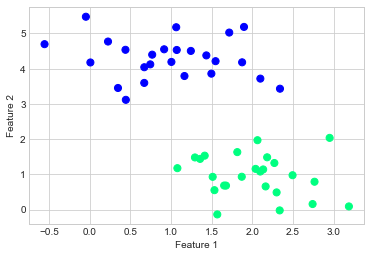

In [3]:
from sklearn.datasets import make_blobs
plt.style.use('seaborn-whitegrid') # 设置 Matplotlib 的绘图风格为 'seaborn-whitegrid'

X, y = make_blobs(n_samples=50, centers=2, # 生成 50 个样本，分为 2 个聚类中心
                  random_state=0, cluster_std=0.60) # 设置随机种子为 0 以保证结果可复现，聚类标准差为 0.60
y[y == 0] = -1 # Change 0 labels to -1 for SVM
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')# 绘制数据的散点图，颜色根据类别 y 值的大小决定，点大小为 50，使用 'winter' 色图
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

### 使用线性核 SVM 训练并可视化决策边界 (C=1.0)

这一部分代码**使用生成的二维数据训练一个线性核 SVM 模型**，并**通过之前定义的 `plot_svm_decision_function` 函数可视化其决策边界、间隔和支持向量**。

训练完成，共进行了 200 次迭代 (最大迭代次数 200)。


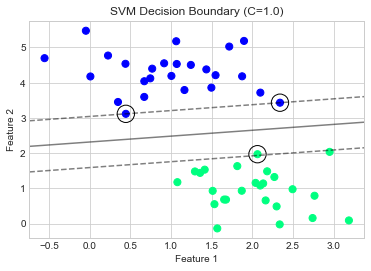

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')# 绘制数据的散点图，颜色根据类别 y 值的大小决定，点大小为 50，使用 'winter' 色图
model_C1 = SVM(C=1.0, kernel='linear', max_iter=200) # C=1.0
model_C1.fit(X, y)

plot_svm_decision_function(model_C1)
plt.title(f"SVM Decision Boundary (C={model_C1.C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

### 探索惩罚参数 C 对线性 SVM 的影响

这个代码块**重新生成了一个带有更多重叠的二分类数据集**，然后**对比展示了不同 `C` 值（1000 和 0.1）下线性 SVM 的决策边界和间隔**。这有助于理解 `C` 参数如何平衡模型复杂度和分类错误。

训练完成，共进行了 200 次迭代 (最大迭代次数 200)。
Accuracy with C=1.0: 100.00%
训练完成，共进行了 200 次迭代 (最大迭代次数 200)。
Accuracy with C=0.1: 100.00%


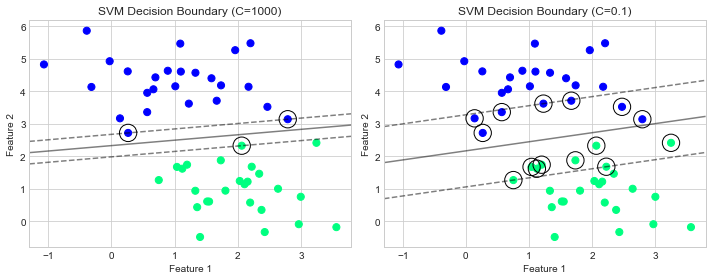

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                    random_state=0, cluster_std=0.80)
y[y == 0] = -1 # Change 0 labels to -1 for SVM

plt.figure(figsize=(10, 4))

# --- Plotting with C=1.0 ---
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
model_C1 = SVM(C=1000, kernel='linear', max_iter=200) # C=1.0
model_C1.fit(X, y)



plot_svm_decision_function(model_C1)
plt.title(f"SVM Decision Boundary (C={model_C1.C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
print(f"Accuracy with C=1.0: {model_C1.score(X, y) * 100:.2f}%")


# --- Plotting with C=0.1 (softer margin) ---
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
model_C01 = SVM(C=0.1, kernel='linear', max_iter=200) # C=0.1 (softer margin)
model_C01.fit(X, y)
plot_svm_decision_function(model_C01)
plt.title(f"SVM Decision Boundary (C={model_C01.C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
print(f"Accuracy with C=0.1: {model_C01.score(X, y) * 100:.2f}%")

plt.tight_layout()
plt.show()

### 使用线性核 SVM 处理非线性可分数据

这个代码块**展示了线性核 SVM 在非线性可分数据集（同心圆）上的表现**。由于线性核无法在高维空间中映射数据，它将无法很好地分离同心圆数据。

训练完成，共进行了 200 次迭代 (最大迭代次数 200)。


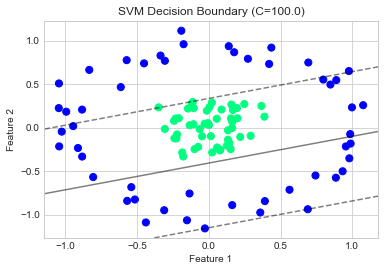

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.2, noise=.1) # 中间间隔大小比例0.2，噪声的标准差0.1
y[y == 0] = -1 # Change 0 labels to -1 for SVM

clf = SVM(C=100.0, kernel='linear', max_iter=200)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svm_decision_function(clf,plot_support=False)
plt.title(f"SVM Decision Boundary (C={clf.C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

### 三维空间中的 RBF 核映射可视化

这个块**展示了径向基函数（RBF）核如何将二维非线性可分数据（同心圆）映射到三维空间**，使其在新空间中变得线性可分。这是核技巧的核心思想。

Text(0.5, 0, 'r')

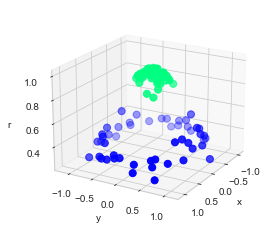

In [7]:
from mpl_toolkits import mplot3d

r = np.exp(-(X ** 2).sum(1))
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')

### 使用 RBF 核 SVM 解决非线性可分问题

这段代码**使用 RBF 核来训练 SVM 模型**，展示了核技巧如何让 SVM 在原始特征空间中呈现非线性的决策边界，从而**有效解决同心圆等非线性可分问题**。

训练完成，共进行了 200 次迭代 (最大迭代次数 200)。


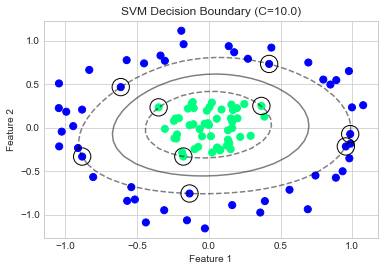

In [8]:
clf = SVM(C=10.0, kernel='rbf', max_iter=200)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svm_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')
plt.title(f"SVM Decision Boundary (C={clf.C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

### 乳腺癌数据集：特征可视化与数据准备

这个代码块**引入了乳腺癌数据集**，并定义了一个**新的函数 `visualize_feature` 用于通过箱线图展示每个特征的分布**。此外，它还**支持特征选择和训练/测试集划分**。

In [9]:
from sklearn.datasets import load_breast_cancer

def visualize_feature(x,name):
    for i in range(len(name)):
        if i<15: # 如果特征索引小于 15 (即前 15 个特征)
            if i==0:
                plt.figure(1,figsize=(20,10))
            plt.subplot(3,5, i+1) # 在当前图表中创建 3x5 的子图网格，并在第 i+1 个位置绘制
            plt.boxplot(x[:,i],patch_artist=True,labels=[name[i]]) # 绘制第 i 列特征的箱线图，并填充颜色，标签为特征名
        else:
            if i==15:
                plt.figure(2,figsize=(20,10))
            plt.subplot(3, 5, i-14)
            plt.boxplot(x[:, i], patch_artist=True, labels=[name[i]])
    plt.show()


def create_data(visualize=True, select=True):
    bc = load_breast_cancer()

    data,target,feature_names=bc.data,bc.target,bc.feature_names # 解包数据集：数据、目标标签、特征名称
    target=target*2-1
    print("data shape:",data.shape)
    print("label shape:",target.shape)
    if visualize:
        visualize_feature(data,feature_names)
    if select:
        # 选用特定的特征列
        selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 24, 27]
        data = data[:, selected_indices]
        print(f"Using selected features: {[feature_names[i] for i in selected_indices]}")
        print("data shape:",data.shape)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=100) # 30% 用于测试，70% 用于训练，设置随机种子
    return X_train, X_test, y_train, y_test


### 乳腺癌数据集：数据加载与特征标准化

这个块**加载乳腺癌数据集（不进行特征选择）**，并**对特征进行标准化处理**。标准化对于许多机器学习算法（尤其是使用核函数的 SVM）来说是至关重要的预处理步骤。


--- Running SVM on Breast Cancer Dataset ---
data shape: (569, 30)
label shape: (569,)


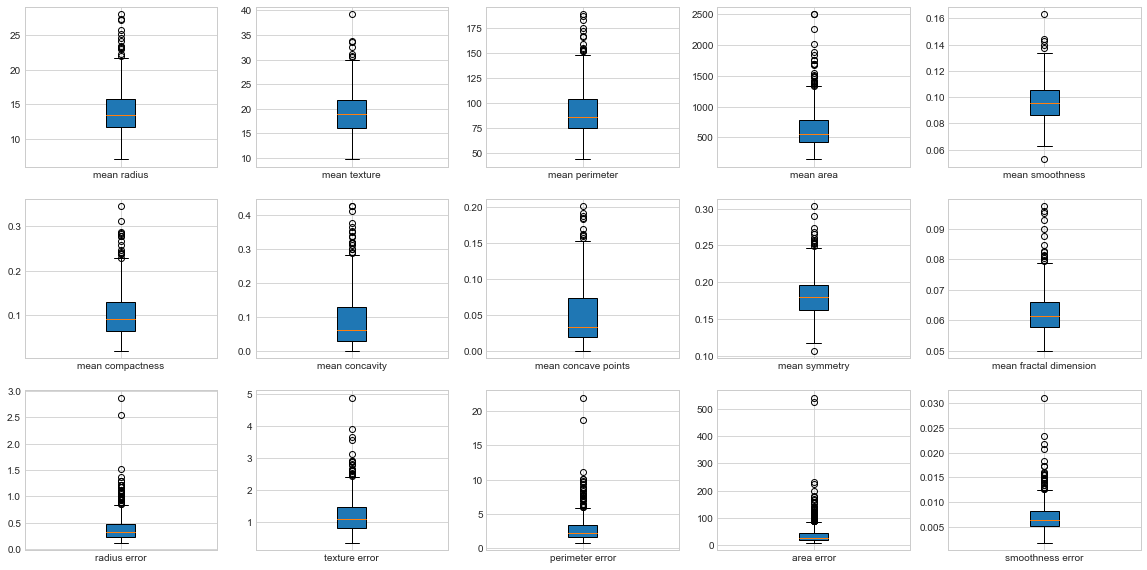

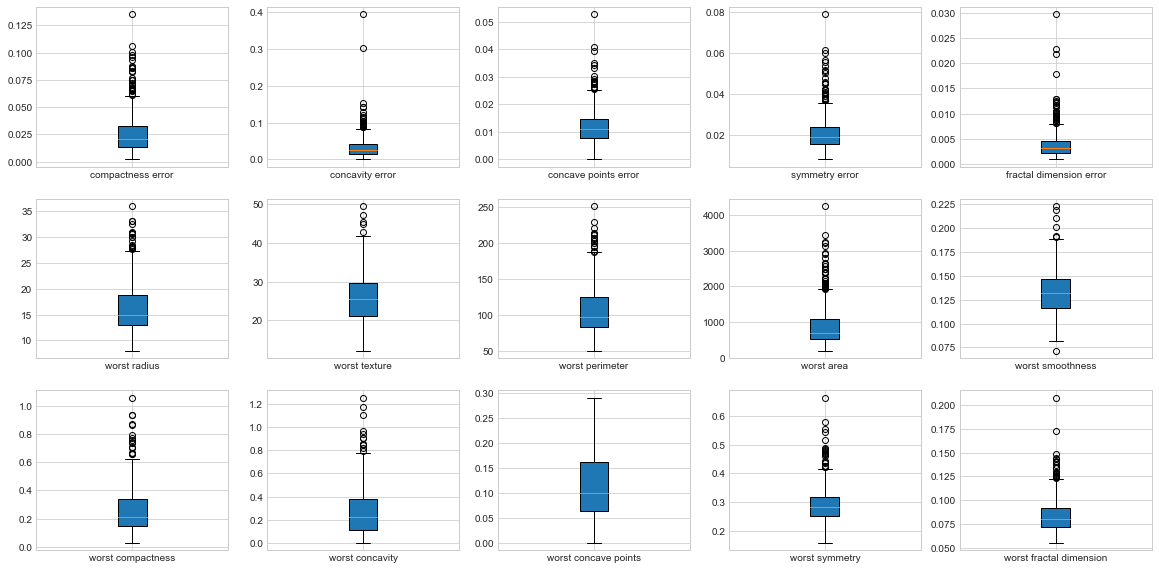

In [10]:
from sklearn.preprocessing import StandardScaler # Added for feature scaling

 # --- Breast Cancer Dataset Analysis ---
print("\n--- Running SVM on Breast Cancer Dataset ---")

X_train, X_test, y_train, y_test = create_data(visualize=True,select=False) #True or False

scaler = StandardScaler() # 创建一个 StandardScaler 实例
X_train_scaled = scaler.fit_transform(X_train) # 对训练数据进行标准化 (计算均值和标准差并应用转换)
X_test_scaled = scaler.transform(X_test) # 使用训练数据计算的均值和标准差对测试数据进行标准化 (只应用转换)

### 乳腺癌数据集：线性 SVM 训练与迭代准确率

这段代码**使用线性核 SVM 训练乳腺癌数据集（全特征、标准化后）**，并**记录并绘制模型在每个迭代步骤（pass）中在测试集上的准确率**，以观察模型的收敛过程。

训练完成，共进行了 50 次迭代 (最大迭代次数 50)。


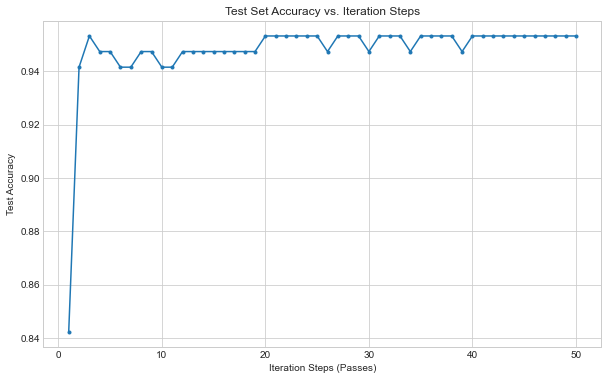

Test Set Accuracy: 0.9532163742690059


In [11]:
max_iter=50

model_C2 = SVM(C=1.0, kernel='linear', max_iter=max_iter) # C=1.0
a=model_C2.fit(X_train_scaled, y_train, X_test_scaled, y_test)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iter + 1), a, marker='o', markersize=3, linestyle='-')
plt.title('Test Set Accuracy vs. Iteration Steps')
plt.xlabel('Iteration Steps (Passes)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

print('Test Set Accuracy:',model_C2.score(X_test_scaled, y_test))

### 乳腺癌数据集：线性 SVM 训练与迭代准确率（特征选择后）

此代码块**重复了上一个实验**，但这次**在加载乳腺癌数据集时进行了特征选择**。它再次展示了线性核 SVM 在标准化后的精选特征集上的训练过程和迭代准确率。


--- Running SVM on Breast Cancer Dataset ---
data shape: (569, 30)
label shape: (569,)
Using selected features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'worst texture', 'worst smoothness', 'worst concave points']
data shape: (569, 13)
训练完成，共进行了 50 次迭代 (最大迭代次数 50)。


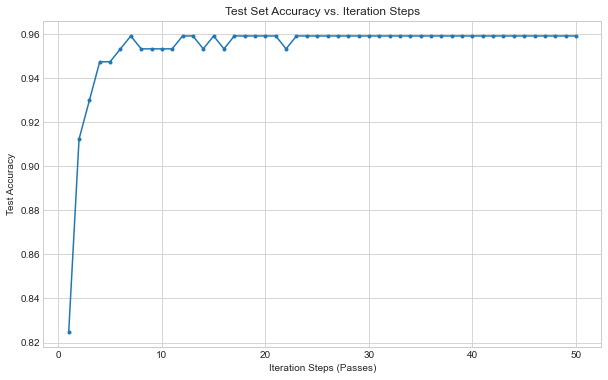

Test Set Accuracy: 0.9590643274853801


In [13]:
from sklearn.preprocessing import StandardScaler # Added for feature scaling

 # --- Breast Cancer Dataset Analysis ---
print("\n--- Running SVM on Breast Cancer Dataset ---")

X_train, X_test, y_train, y_test = create_data(visualize=False,select=True) #True or False

scaler = StandardScaler() # 创建一个 StandardScaler 实例
X_train_scaled = scaler.fit_transform(X_train) # 对训练数据进行标准化 (计算均值和标准差并应用转换)
X_test_scaled = scaler.transform(X_test) # 使用训练数据计算的均值和标准差对测试数据进行标准化 (只应用转换)
max_iter=50

model_C2 = SVM(C=1.0, kernel='linear', max_iter=max_iter) # C=1.0
a=model_C2.fit(X_train_scaled, y_train, X_test_scaled, y_test)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iter + 1), a, marker='o', markersize=3, linestyle='-')
plt.title('Test Set Accuracy vs. Iteration Steps')
plt.xlabel('Iteration Steps (Passes)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

print('Test Set Accuracy:',model_C2.score(X_test_scaled, y_test))